#### Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot styling
plt.style.use('ggplot')
sns.set_context("notebook")

#### Load Data

In [2]:
# Load Datasets
df_fiscal = pd.read_csv('production_daily.csv', parse_dates=['Date'])
df_tests = pd.read_csv('well_tests.csv', parse_dates=['Date'])
df_zones = pd.read_csv('well_zone_splits.csv')

print(f"Fiscal Data Range: {df_fiscal['Date'].min()} to {df_fiscal['Date'].max()}")
print(f"Unique Wells: {df_tests['Well_ID'].nunique()}")

Fiscal Data Range: 2014-01-01 00:00:00 to 2023-12-29 00:00:00
Unique Wells: 10


#### Calculate Theoretical Daily Rates (Estimation)
To better understand the input data, this diagram represents the Test Separator where the individual well test data ($q_{test}$) comes from.

We must transform sparse monthly test data into dense daily data.

In [3]:
# Create a master daily DataFrame
master_df = pd.DataFrame({'Date': df_fiscal['Date']})

# Pivot tests to have Wells as columns
df_tests_pivot = df_tests.pivot(index='Date', columns='Well_ID', values='Test_Rate_BOPD')

# Reindex to daily frequency and Interpolate
# Note: In reality, you might use 'ffill' (Forward Fill) if you assume rate stays constant until next test
df_theoretical = df_tests_pivot.reindex(master_df['Date']).interpolate(method='linear', limit_direction='both')

# Add 'Theoretical_Total' column
df_theoretical['Theoretical_Total'] = df_theoretical.sum(axis=1)

# Merge with Fiscal Meter
df_calc = pd.merge(df_fiscal, df_theoretical['Theoretical_Total'], on='Date')
df_calc.head()

,Date,Fiscal_Meter_BOPD,Theoretical_Total
0,2014-01-01,5238.25,5380.48
1,2014-01-02,5134.84,5380.48
2,2014-01-03,4902.43,5380.48
3,2014-01-04,5184.88,5380.48
4,2014-01-05,4997.79,5380.48


#### Calculate Allocation Factor (PAF)
We calculate the discrepancy between the Fiscal Meter (the "Cash Register") and the Theoretical Total.

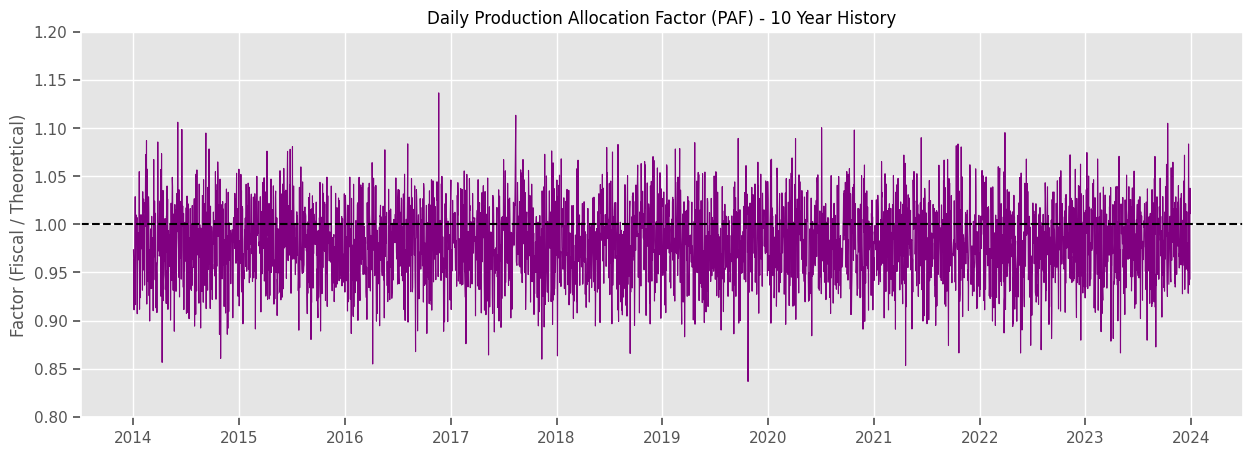

In [4]:
# Calculate Factor
df_calc['Allocation_Factor'] = df_calc['Fiscal_Meter_BOPD'] / df_calc['Theoretical_Total']

# Visualization: Allocation Factor Stability
plt.figure(figsize=(15, 5))
plt.plot(df_calc['Date'], df_calc['Allocation_Factor'], color='purple', linewidth=0.8)
plt.axhline(1.0, color='black', linestyle='--')
plt.title('Daily Production Allocation Factor (PAF) - 10 Year History')
plt.ylabel('Factor (Fiscal / Theoretical)')
plt.ylim(0.8, 1.2) # Focus on relevant variance
plt.show()

#### Back-Allocate to Wells
Multiply the daily Factor by the daily theoretical rate for each well.

In [5]:
# Create Allocated DataFrame
df_allocated = df_theoretical.drop(columns=['Theoretical_Total']).multiply(df_calc['Allocation_Factor'].values, axis=0)

# Sanity Check: The sum of allocated wells MUST equal Fiscal Meter
check_sum = df_allocated.sum(axis=1)
diff = (check_sum - df_calc['Fiscal_Meter_BOPD']).sum()
print(f"Total Cumulative Discrepancy after Allocation: {round(diff, 4)} bbls (Should be ~0)")

Total Cumulative Discrepancy after Allocation: 0.0 bbls (Should be ~0)


#### Zone Interest Calculation
Distribute well production into the 4 zones.

/var/folders/js/mq0w90jn29j3rm43w56mdpy80000gn/T/ipykernel_81000/654140148.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  zone_production = pd.DataFrame(index=df_allocated.index, columns=['Zone_A', 'Zone_B', 'Zone_C', 'Zone_D']).fillna(0.0)


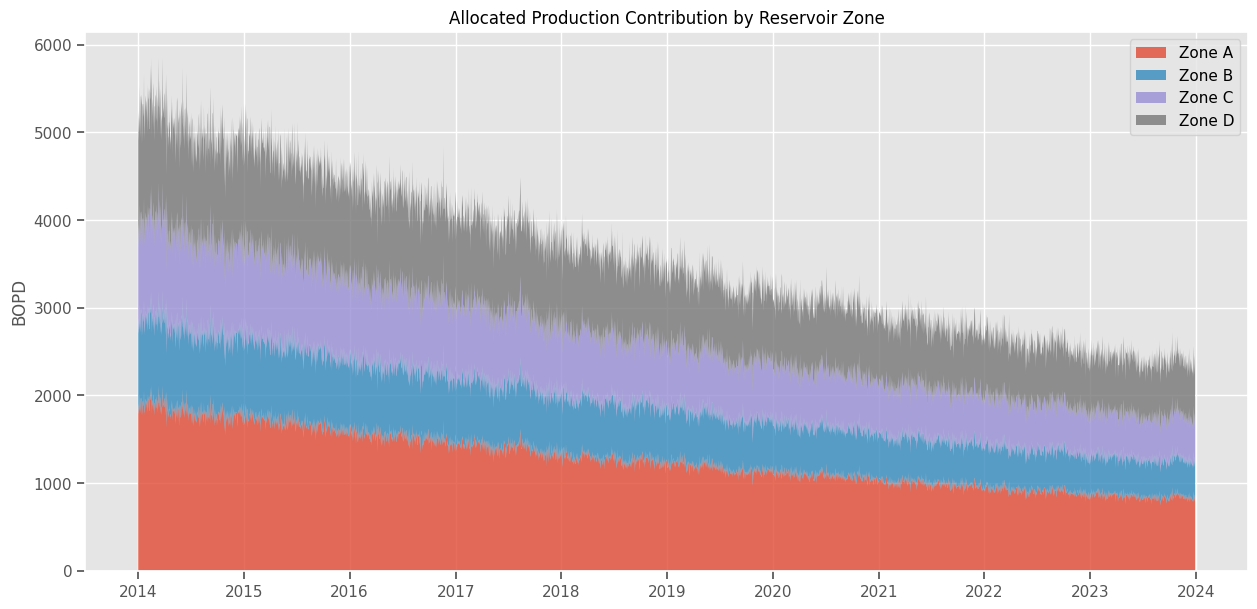

In [6]:
# Initialize Zone DataFrames
zone_production = pd.DataFrame(index=df_allocated.index, columns=['Zone_A', 'Zone_B', 'Zone_C', 'Zone_D']).fillna(0.0)

for well in df_allocated.columns:
    # Get split factors for this well
    splits = df_zones[df_zones['Well_ID'] == well].iloc[0]
    
    # Add this well's contribution to each zone
    zone_production['Zone_A'] += df_allocated[well] * splits['Zone_A']
    zone_production['Zone_B'] += df_allocated[well] * splits['Zone_B']
    zone_production['Zone_C'] += df_allocated[well] * splits['Zone_C']
    zone_production['Zone_D'] += df_allocated[well] * splits['Zone_D']

# Visualization: Production by Zone
plt.figure(figsize=(15, 7))
plt.stackplot(zone_production.index, 
              zone_production['Zone_A'], zone_production['Zone_B'], 
              zone_production['Zone_C'], zone_production['Zone_D'],
              labels=['Zone A', 'Zone B', 'Zone C', 'Zone D'], alpha=0.8)
plt.legend(loc='upper right')
plt.title('Allocated Production Contribution by Reservoir Zone')
plt.ylabel('BOPD')
plt.show()